In [5]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from imdb import IMDb
import time
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
import joblib
from sklearn.metrics import mean_absolute_error


In [6]:

def scrape_movie_names(url):
    firefox_options = webdriver.FirefoxOptions()
    firefox_options.set_preference("general.useragent.override",
                                   "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/115.0")
    firefox_options.set_preference("dom.webdriver.enabled", False)

    driver = webdriver.Firefox(
        service=FirefoxService(GeckoDriverManager().install()),
        options=firefox_options
    )
    driver.get(url)

    try:
        WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, ".ipc-metadata-list-summary-item"))
        )

        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        movies_elements = driver.find_elements(By.CSS_SELECTOR, ".ipc-metadata-list-summary-item")
        movie_names = []

        for movie in movies_elements:
            try:
                title = movie.find_element(By.CSS_SELECTOR, "h3.ipc-title__text").text
                cleaned_title = title.split('. ', 1)[-1] if '. ' in title else title
                movie_names.append(cleaned_title)
            except Exception as e:
                print(f"Error extracting movie title: {str(e)[:50]}...")
                continue

    except Exception as e:
        print("An error occurred while fetching data:", e)
        movie_names = []
    finally:
        driver.quit()

    return movie_names

In [7]:

def get_movie_details(movie_name):
    ia = IMDb()
    movies = ia.search_movie(movie_name)

    if not movies:
        return None

    movie = movies[0]
    ia.update(movie)
    runtime = movie.get('runtimes', ['N/A'])[0] + " min" if movie.get('runtimes') else "N/A"
    votes = "{:,}".format(movie.get('votes', 0)) if movie.get('votes') else "N/A"

    details = {
        "Title": movie.get('title', 'N/A'),
        "Release Year": movie.get('year', 'N/A'),
        "Director": ', '.join([d['name'] for d in movie.get('directors', [])][:3]),
        "Main Actors": ', '.join([a['name'] for a in movie.get('cast', [])][:5]),
        "Genre": ', '.join(movie.get('genres', ['N/A'])),
        "Rating": str(movie.get('rating', 'N/A')) + "/10",
        "Duration": runtime,
        "Votes": votes
    }
    return details

In [8]:
if __name__ == "__main__":
    imdb_url = "https://www.imdb.com/chart/top/"
    movies_list = scrape_movie_names(imdb_url)
    all_movies_data = []

    for idx, movie_name in enumerate(movies_list, 1):
        print(f"\nFetching movie details No.{idx}: {movie_name}...")
        details = get_movie_details(movie_name)

        if details:
            print(f"Title: {details['Title']}")
            print(f"Year: {details['Release Year']}")
            print(f"Director: {details['Director']}")
            print(f"Cast: {details['Main Actors']}")
            print(f"Genre: {details['Genre']}")
            print(f"Rating: {details['Rating']}")
            print(f"Duration: {details['Duration']}")
            print(f"Votes: {details['Votes']}")
            print("-" * 60)
            
            all_movies_data.append(details)
        else:
            print(f"No details available for the movie: {movie_name}")

        time.sleep(2)  
    if all_movies_data: 
        df = pd.DataFrame(all_movies_data)
    else:
        print("\nNo movies data was fetched.")


Fetching movie details No.1: The Shawshank Redemption...
Title: The Shawshank Redemption
Year: 1994
Director: Frank Darabont
Cast: Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler, Clancy Brown
Genre: Drama
Rating: 9.3/10
Duration: 142 min
Votes: 3,038,284
------------------------------------------------------------

Fetching movie details No.2: The Godfather...
Title: The Godfather
Year: 1972
Director: Francis Ford Coppola
Cast: Marlon Brando, Al Pacino, James Caan, Richard S. Castellano, Robert Duvall
Genre: Crime, Drama
Rating: 9.2/10
Duration: 175 min
Votes: 2,120,846
------------------------------------------------------------

Fetching movie details No.3: The Dark Knight...
Title: The Dark Knight
Year: 2008
Director: Christopher Nolan
Cast: Christian Bale, Heath Ledger, Aaron Eckhart, Michael Caine, Maggie Gyllenhaal
Genre: Action, Crime, Drama, Thriller
Rating: 9.0/10
Duration: 152 min
Votes: 3,015,043
------------------------------------------------------------

Fetchin

In [9]:
df.head()

print(df.info())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         250 non-null    object
 1   Release Year  250 non-null    object
 2   Director      250 non-null    object
 3   Main Actors   250 non-null    object
 4   Genre         250 non-null    object
 5   Rating        250 non-null    object
 6   Duration      250 non-null    object
 7   Votes         250 non-null    object
dtypes: object(8)
memory usage: 15.8+ KB
None
                           Title  Release Year           Director Main Actors  \
count                        250           250                250         250   
unique                       250            83                160         246   
top     The Shawshank Redemption          1995  Christopher Nolan               
freq                           1             8                  8           4   

        Genre  Rating Du

In [10]:
df.replace('N/A', np.nan, inplace=True)
df.dropna(inplace=True)

C:\Users\ayaYM\AppData\Local\Temp\ipykernel_24408\1536340378.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('N/A', np.nan, inplace=True)


In [11]:
df['Release Year'] = df['Release Year'].astype('Int64')
df['Rating'] = df['Rating'].astype(str).str.replace('/10', '').astype(float)
df['Duration'] = df['Duration'].astype(str).str.extract(r'(\d+)').astype(float)
df['Votes'] = df['Votes'].astype(str).str.replace(',', '').astype(float)
df.dropna(subset=['Rating', 'Duration', 'Votes', 'Release Year'], inplace=True)


In [12]:
# 8. إعادة ترتيب الأعمدة (اختياري)
df = df[['Title', 'Release Year', 'Director', 'Main Actors', 'Genre', 'Rating', 'Duration', 'Votes']]


In [13]:
print(df.info())  
print(df.head())
print(df.describe())
print(df.isna().sum())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 0 to 249
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         245 non-null    object 
 1   Release Year  245 non-null    Int64  
 2   Director      245 non-null    object 
 3   Main Actors   245 non-null    object 
 4   Genre         245 non-null    object 
 5   Rating        245 non-null    float64
 6   Duration      245 non-null    float64
 7   Votes         245 non-null    float64
dtypes: Int64(1), float64(3), object(4)
memory usage: 17.5+ KB
None
                      Title  Release Year              Director  \
0  The Shawshank Redemption          1994        Frank Darabont   
1             The Godfather          1972  Francis Ford Coppola   
2           The Dark Knight          2008     Christopher Nolan   
3     The Godfather Part II          1974  Francis Ford Coppola   
4              12 Angry Men          1957          Sidney Lumet   



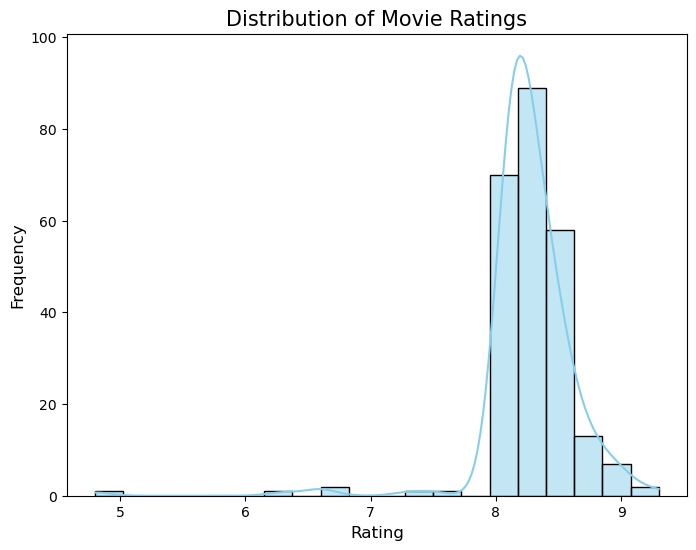

In [14]:
# Rating Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


C:\Users\ayaYM\AppData\Local\Temp\ipykernel_24408\1728201979.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Release Year', palette='viridis')


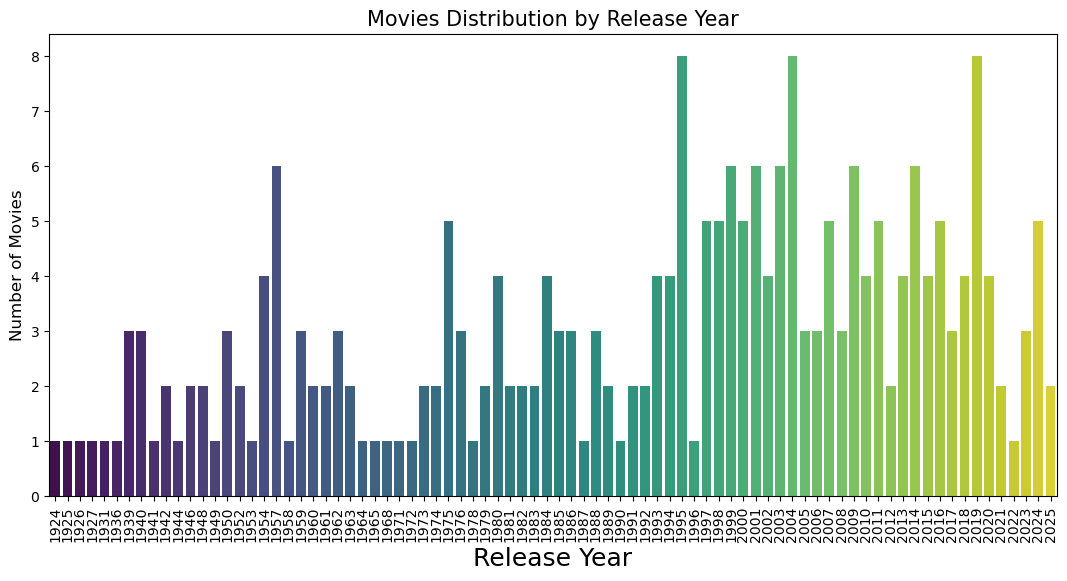

In [15]:
# Release Year Distribution
plt.figure(figsize=(13, 6))
sns.countplot(data=df, x='Release Year', palette='viridis')
plt.title('Movies Distribution by Release Year', fontsize=15)
plt.xlabel('Release Year', fontsize=18)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=90)  # لتدوير السنة عشان تكون مقروءة
plt.show()


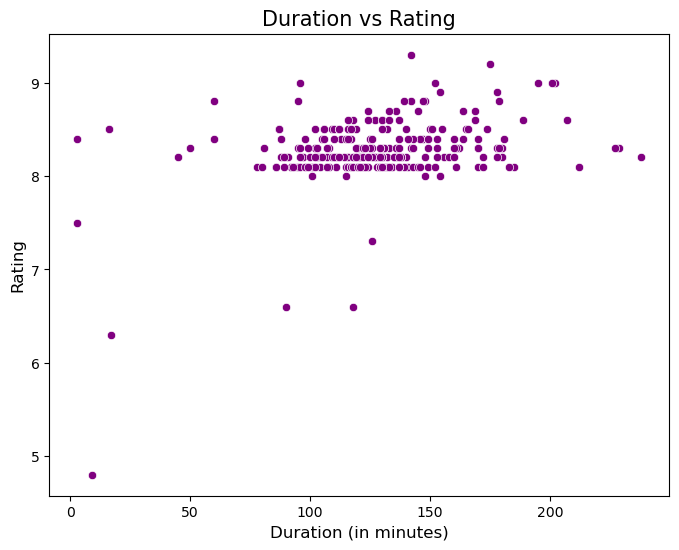

In [16]:
# العلاقة بين المدة (Duration) والتقييمات (Rating)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Duration', y='Rating', color='purple')
plt.title('Duration vs Rating', fontsize=15)
plt.xlabel('Duration (in minutes)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()


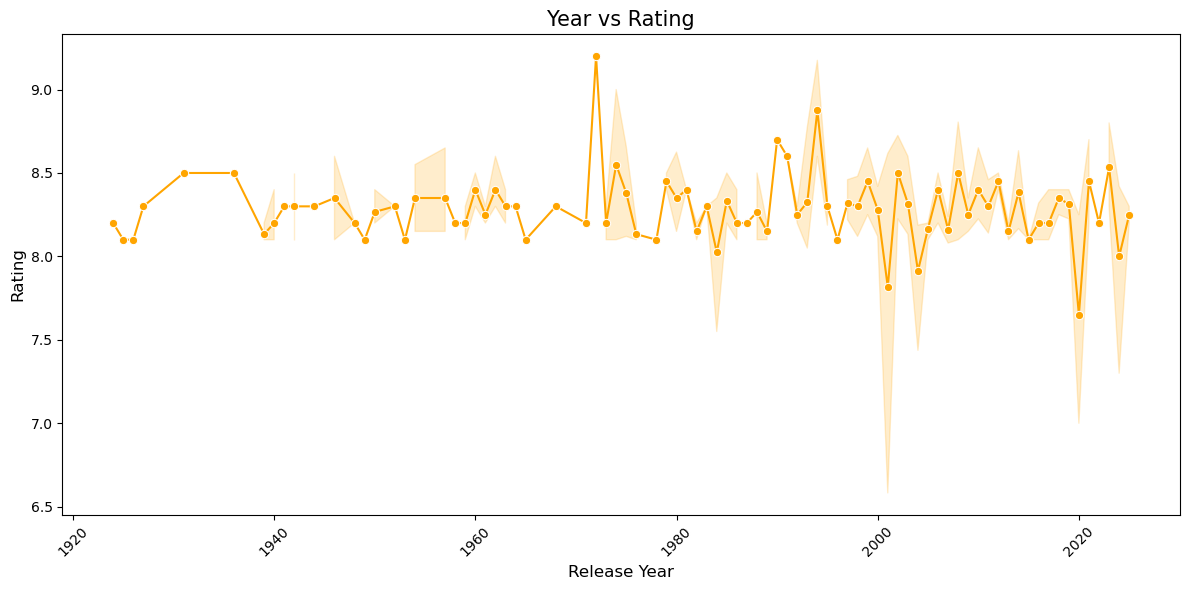

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.sort_values('Release Year'), x='Release Year', y='Rating', marker='o', color='orange')
plt.title('Year vs Rating', fontsize=15)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
fig = px.scatter(
    df,
    x='Votes',
    y='Rating',
    size='Duration',
    color='Genre',
    hover_name='Title',
    title='Votes vs Rating with Duration as Bubble Size',
    size_max=40,
    height=600
)
fig.show()

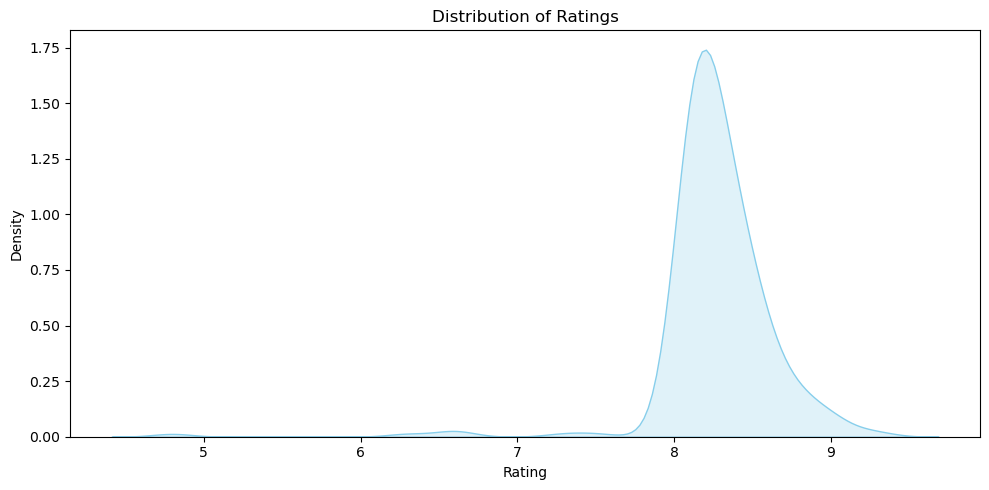

In [19]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df['Rating'], fill=True, color="skyblue")
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


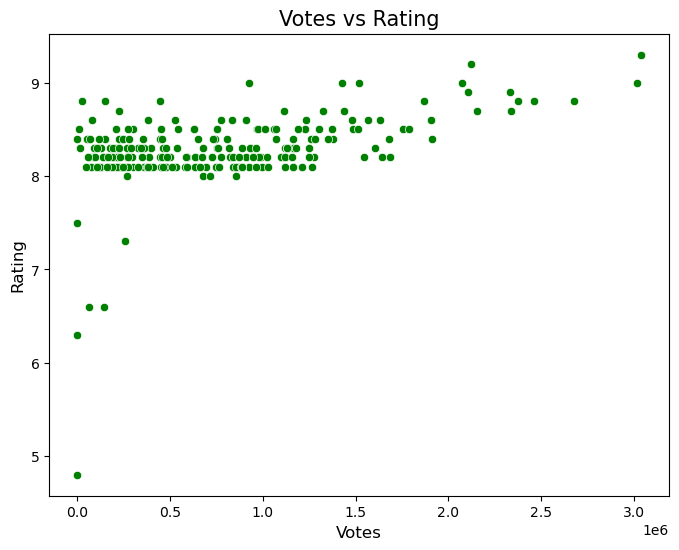

In [20]:
# العلاقة بين التصويتات (Votes) والتقييمات (Rating)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Votes', y='Rating', color='green')
plt.title('Votes vs Rating', fontsize=15)
plt.xlabel('Votes', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()


C:\Users\ayaYM\AppData\Local\Temp\ipykernel_24408\609241873.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




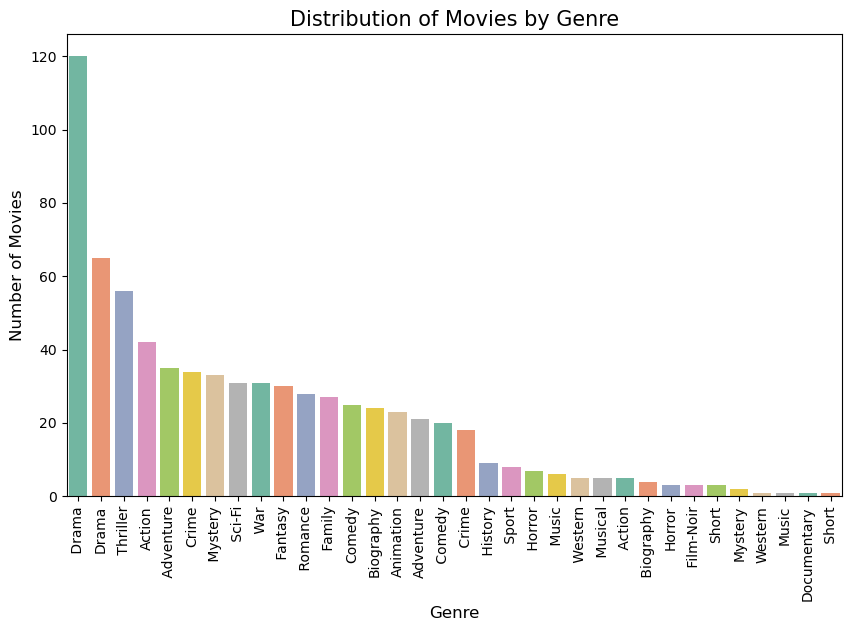

In [21]:
# توزيع الأفلام حسب النوع
plt.figure(figsize=(10, 6))
genre_counts = df['Genre'].str.split(',').explode().value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='Set2')
plt.title('Distribution of Movies by Genre', fontsize=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=90)
plt.show()


C:\Users\ayaYM\AppData\Local\Temp\ipykernel_24408\2094724482.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




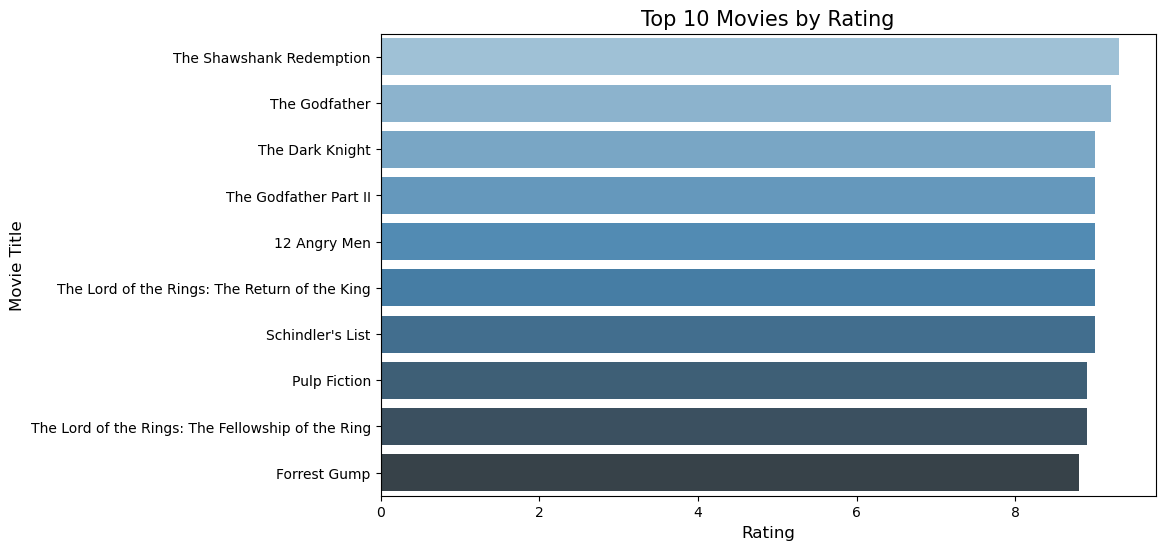

In [22]:
# أفضل 10 أفلام حسب التقييم
top_10_movies = df.nlargest(10, 'Rating')
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_movies, x='Rating', y='Title', palette='Blues_d')
plt.title('Top 10 Movies by Rating', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()


C:\Users\ayaYM\AppData\Local\Temp\ipykernel_24408\3434540857.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




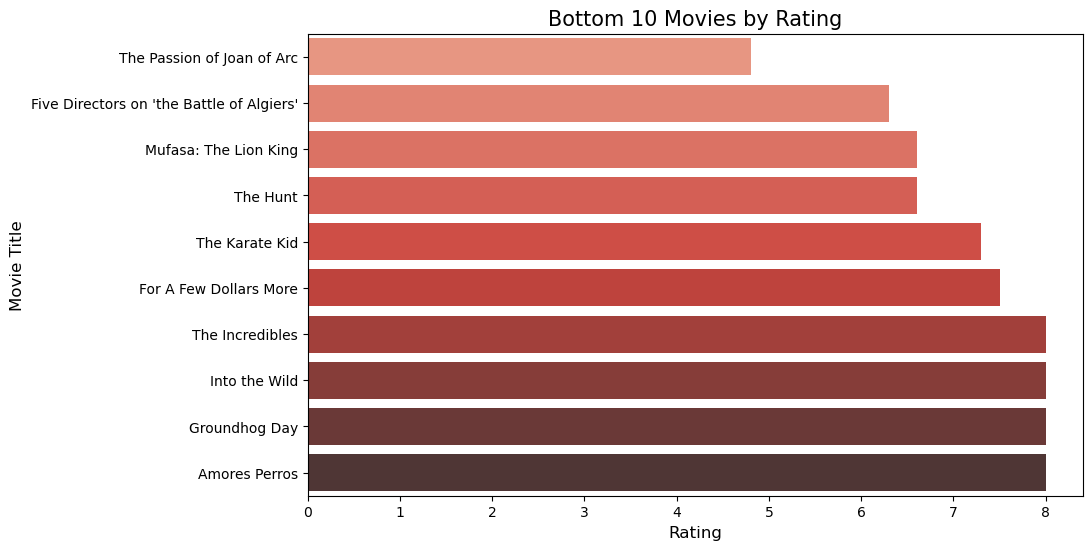

In [23]:
# أسوأ 10 أفلام حسب التقييم
bottom_10_movies = df.nsmallest(10, 'Rating')
plt.figure(figsize=(10, 6))
sns.barplot(data=bottom_10_movies, x='Rating', y='Title', palette='Reds_d')
plt.title('Bottom 10 Movies by Rating', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()


C:\Users\ayaYM\AppData\Local\Temp\ipykernel_24408\2722705741.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




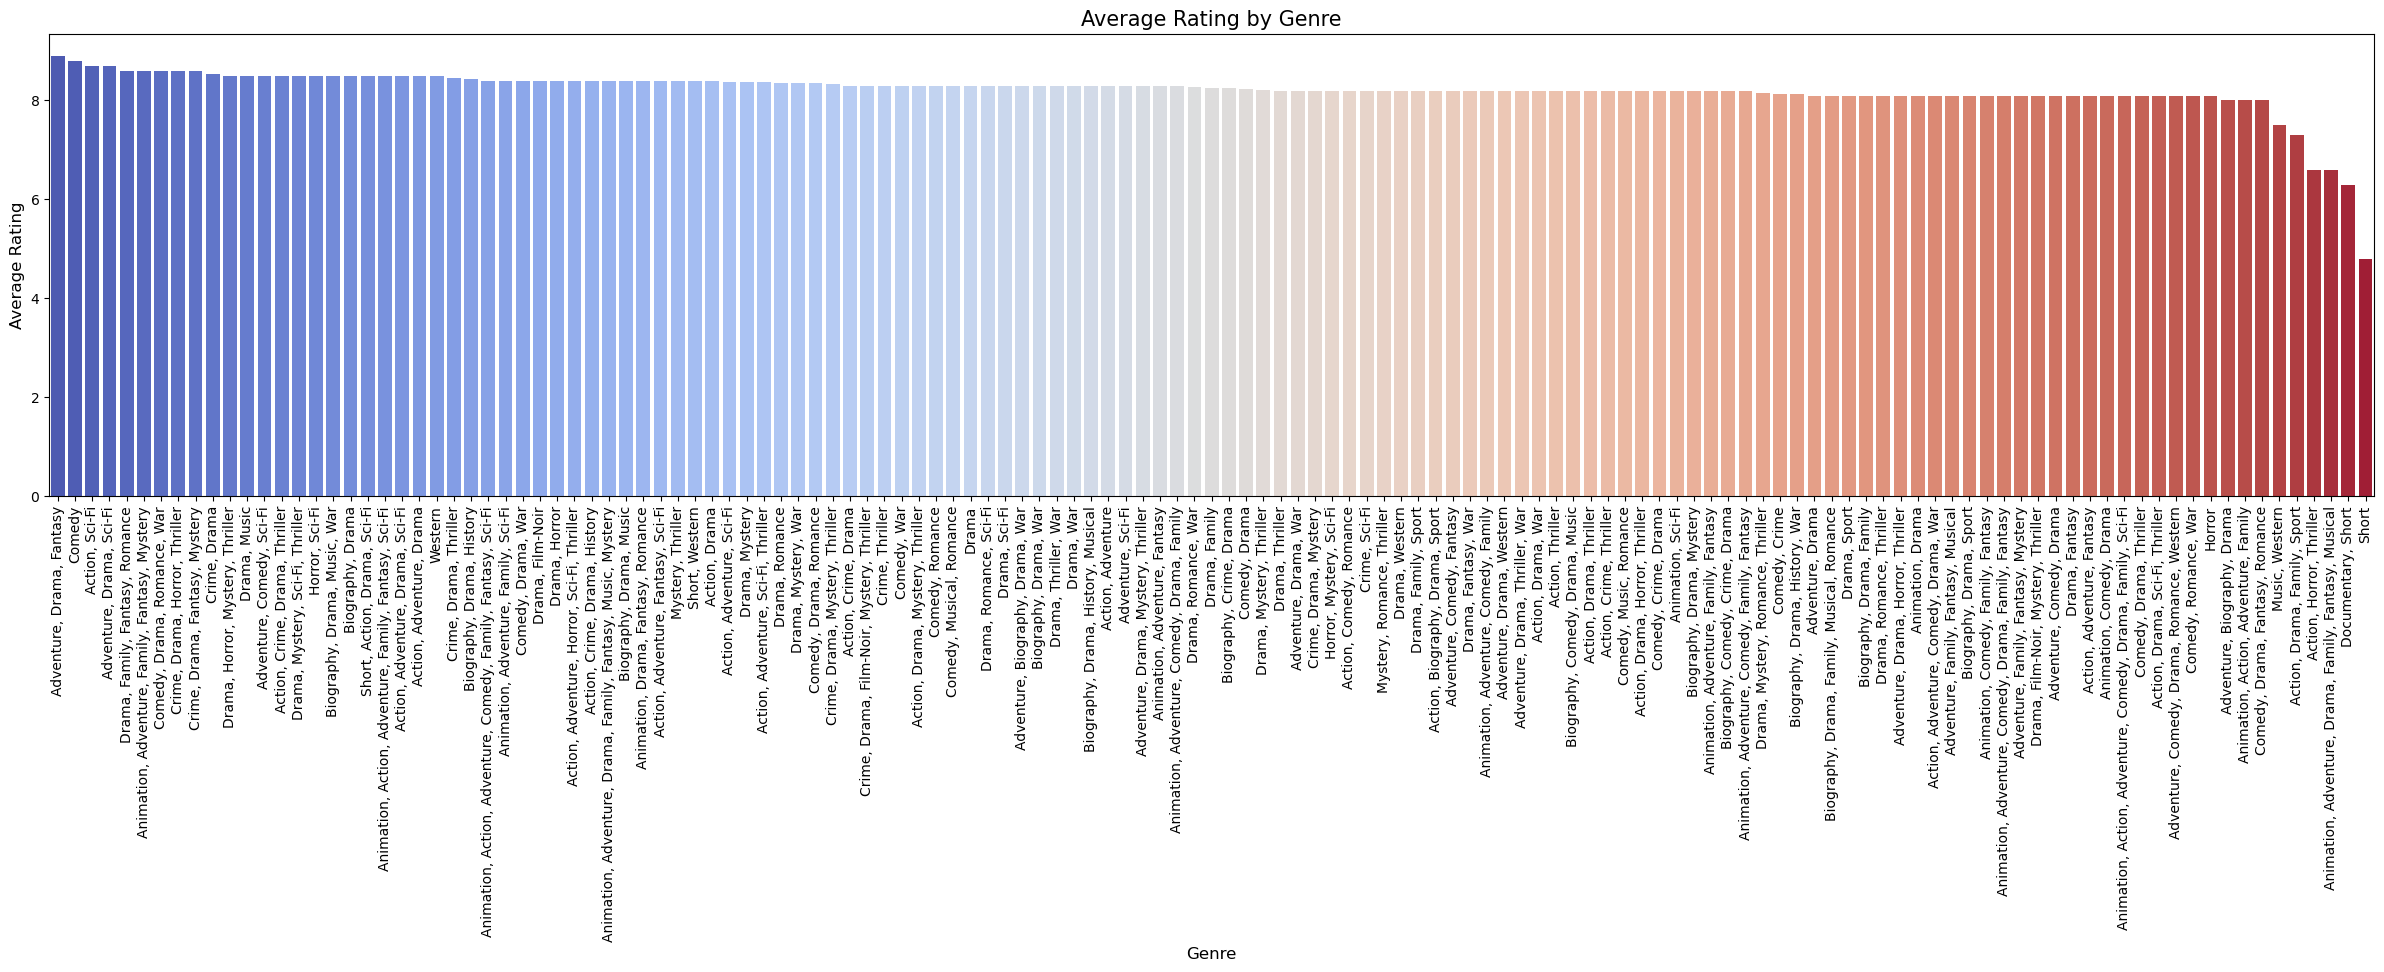

In [24]:
# متوسط التقييم حسب النوع
plt.figure(figsize=(30, 6))
avg_rating_by_genre = df.groupby('Genre')['Rating'].mean().sort_values(ascending=False)
sns.barplot(x=avg_rating_by_genre.index, y=avg_rating_by_genre.values, palette='coolwarm')
plt.title('Average Rating by Genre', fontsize=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=90)
plt.show()


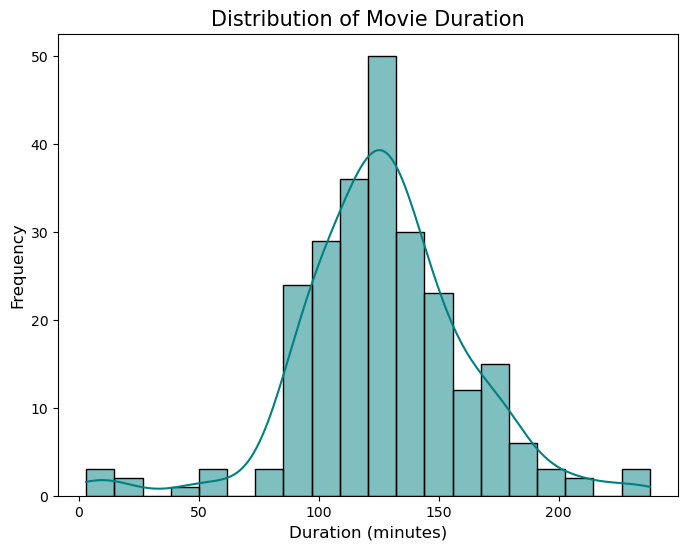

In [25]:
# توزيع المدة
plt.figure(figsize=(8, 6))
sns.histplot(df['Duration'], bins=20, kde=True, color='teal', edgecolor='black')
plt.title('Distribution of Movie Duration', fontsize=15)
plt.xlabel('Duration (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


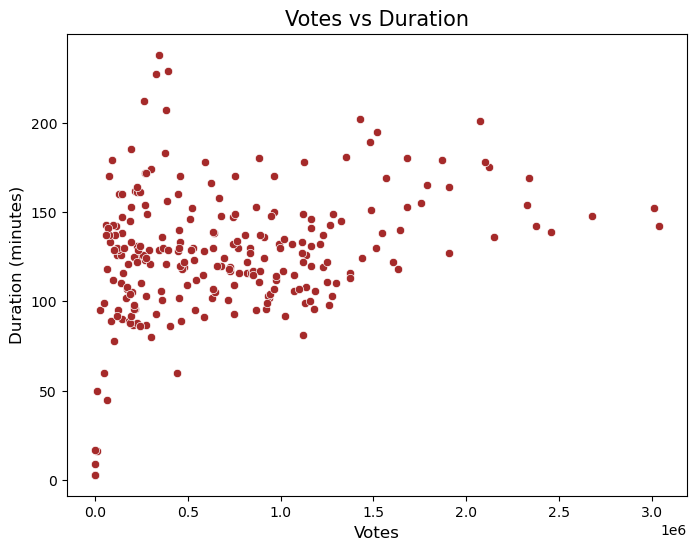

In [26]:
# العلاقة بين التصويتات (Votes) والمدة (Duration)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Votes', y='Duration', color='brown')
plt.title('Votes vs Duration', fontsize=15)
plt.xlabel('Votes', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.show()


C:\Users\ayaYM\AppData\Local\Temp\ipykernel_24408\36952098.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




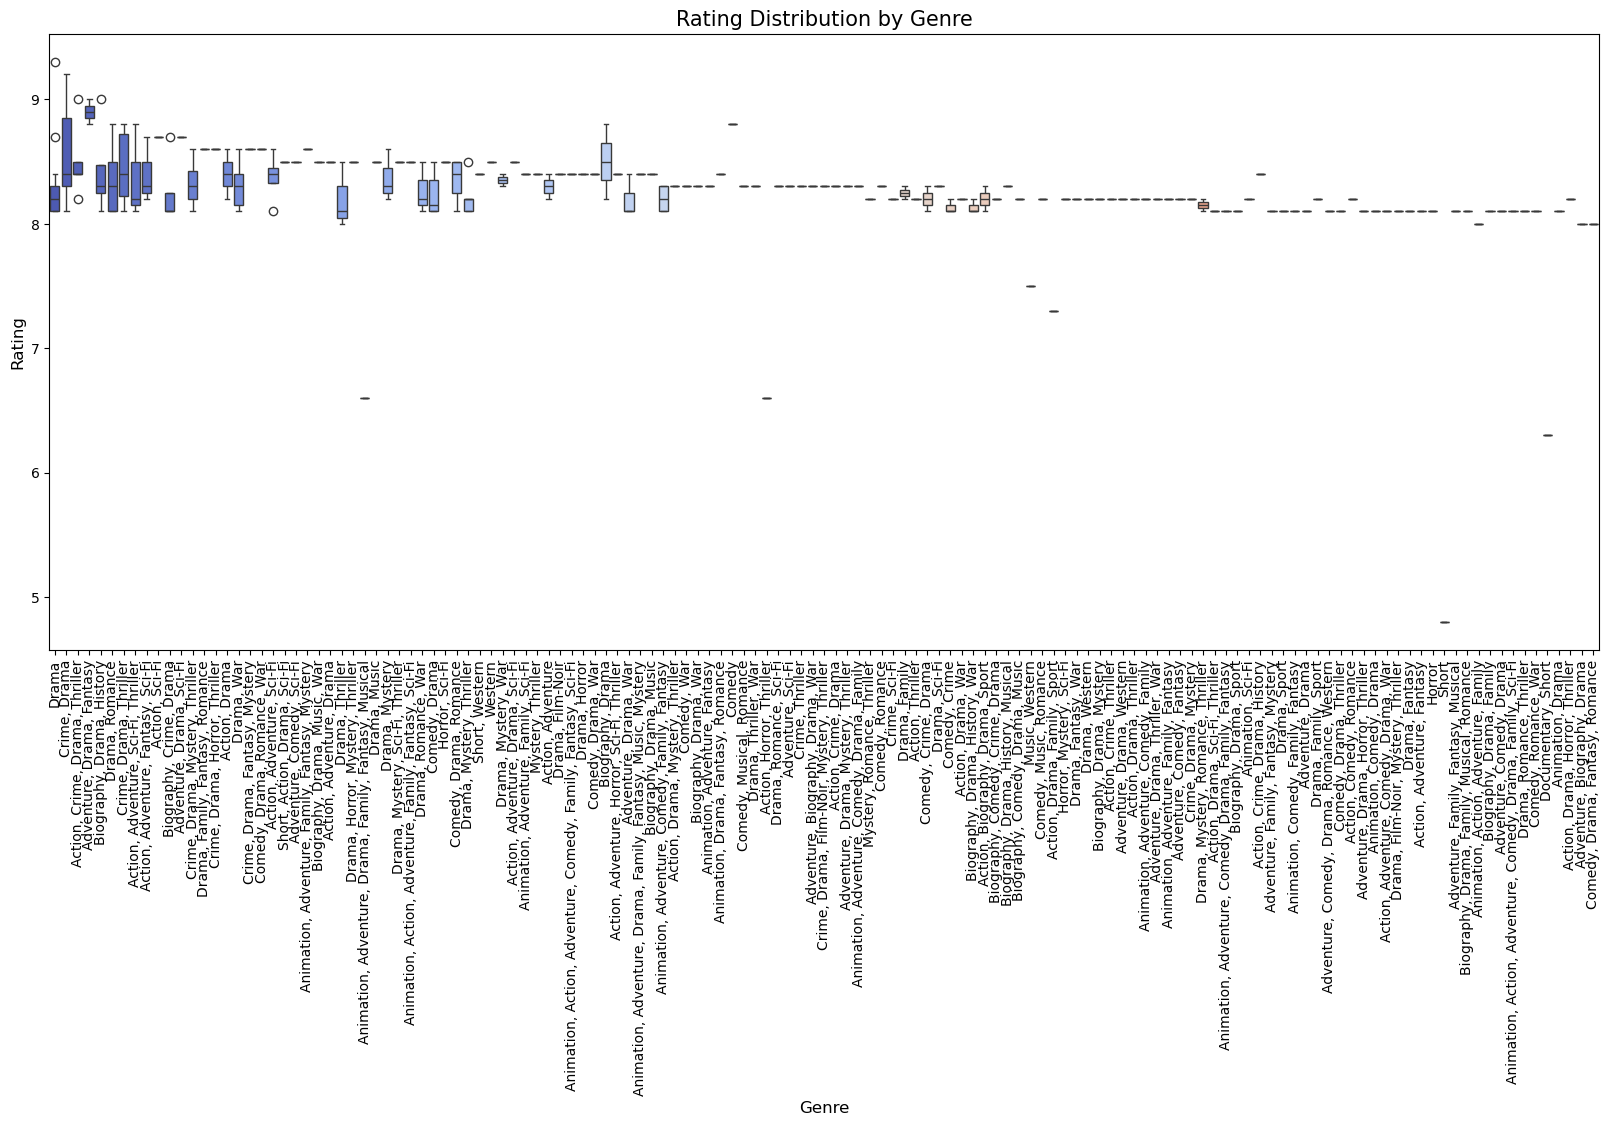

In [27]:
# Box Plot للتقييمات حسب النوع
plt.figure(figsize=(20, 8))
sns.boxplot(data=df, x='Genre', y='Rating', palette='coolwarm')
plt.title('Rating Distribution by Genre', fontsize=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=90)
plt.show()


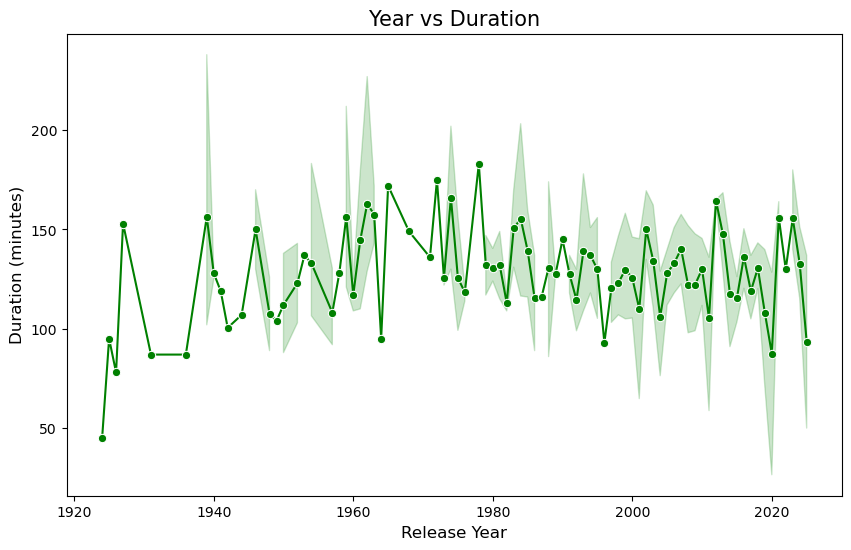

In [28]:
# العلاقة بين السنة والمدة
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Release Year', y='Duration', color='green', marker='o')
plt.title('Year vs Duration', fontsize=15)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.show()


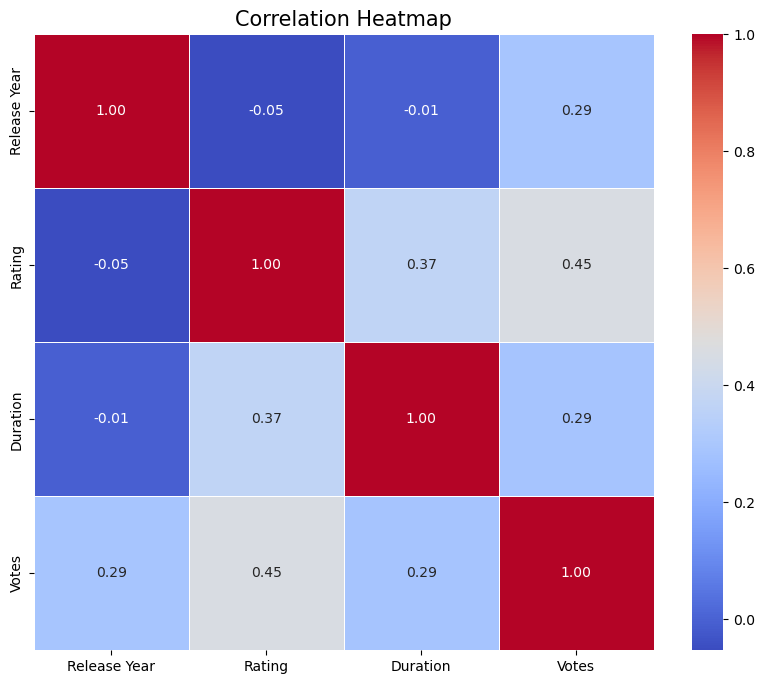

In [29]:
# Heatmap للعلاقات بين المتغيرات
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Release Year', 'Rating', 'Duration', 'Votes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=15)
plt.show()


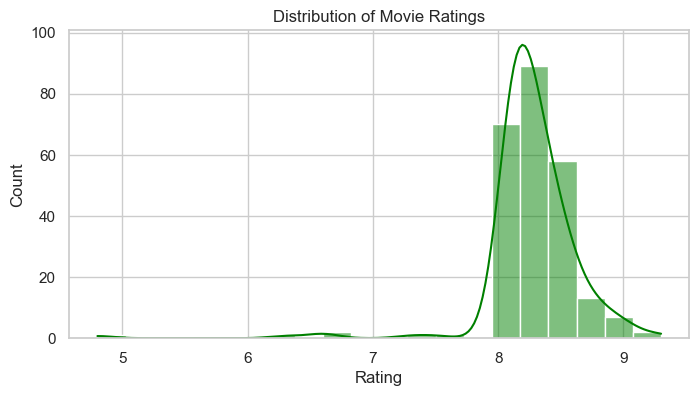

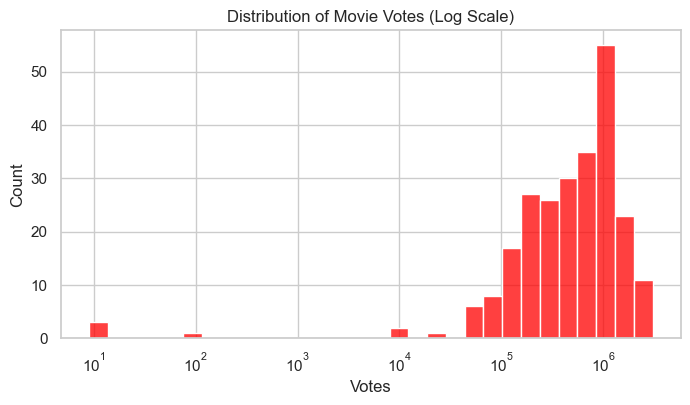

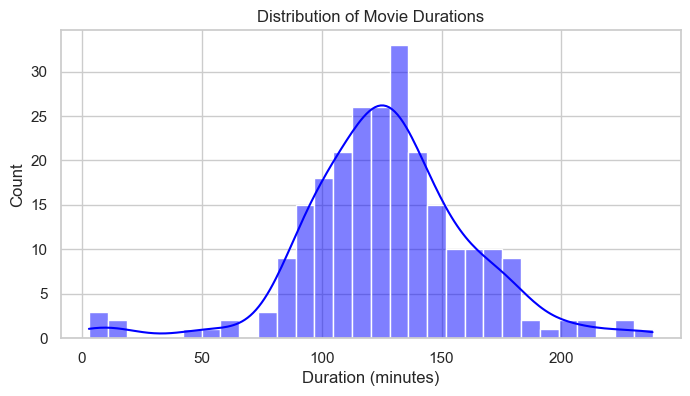

In [30]:
sns.set(style="whitegrid")

# 1. توزيع Rating
plt.figure(figsize=(8, 4))
sns.histplot(df['Rating'], bins=20, kde=True, color='green')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 2. توزيع Votes (باستخدام مقياس لوغاريتمي)
plt.figure(figsize=(8, 4))
sns.histplot(df['Votes'], bins=30, log_scale=True, color='red')
plt.title('Distribution of Movie Votes (Log Scale)')
plt.xlabel('Votes')
plt.ylabel('Count')
plt.show()

# 3. توزيع Duration
plt.figure(figsize=(8, 4))
sns.histplot(df['Duration'], bins=30, kde=True, color='blue')
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.show()


C:\Users\ayaYM\AppData\Local\Temp\ipykernel_24408\3512307462.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




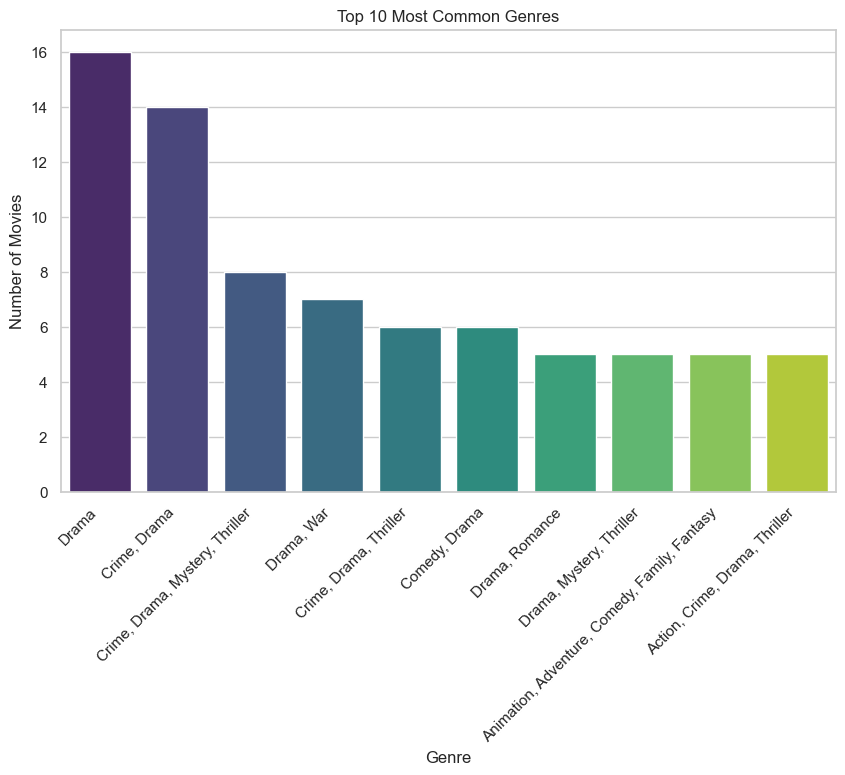

In [31]:
# 1. Bar Chart: عدد الأفلام في كل نوع (Genre)
plt.figure(figsize=(10, 6))
genre_counts = df['Genre'].value_counts().head(10)  # لعرض أفضل 10 أنواع
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Top 10 Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()


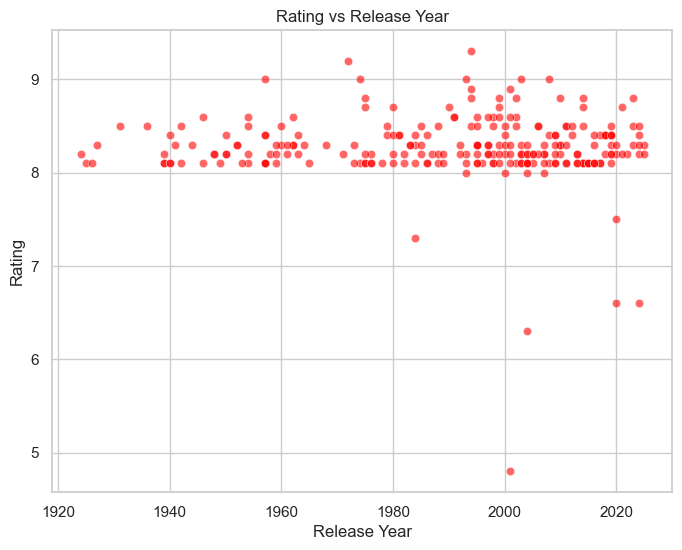

In [32]:
# 3. Scatter Plot: العلاقة بين التقييمات وسنة الإصدار
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Release Year'], y=df['Rating'], color='red', alpha=0.6)
plt.title('Rating vs Release Year')
plt.xlabel('Release Year')
plt.ylabel('Rating')
plt.show()


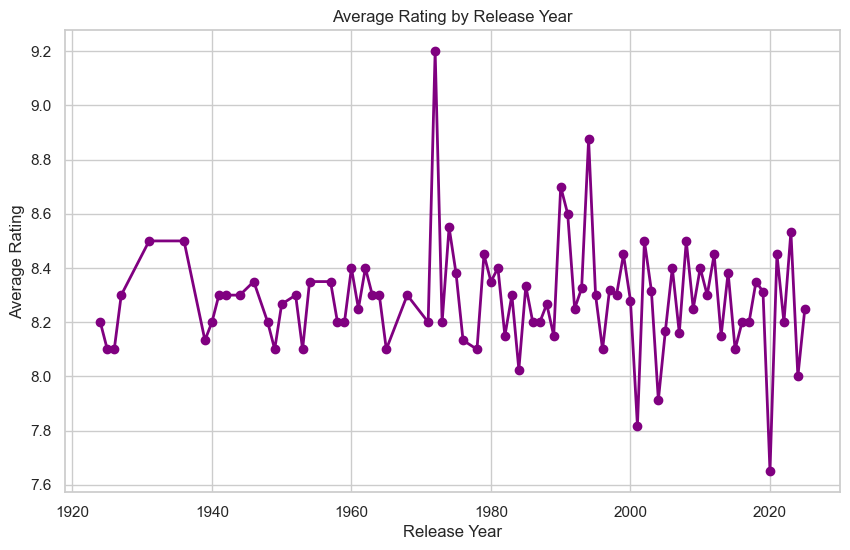

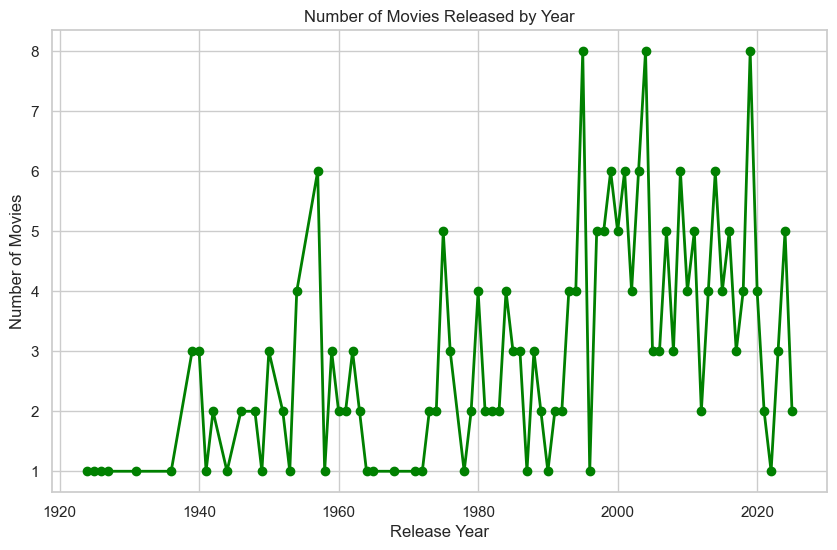

In [33]:
# 4. Line Chart: اتجاهات التقييمات عبر السنين
avg_rating_per_year = df.groupby('Release Year')['Rating'].mean()  # متوسط التقييمات لكل سنة
plt.figure(figsize=(10, 6))
avg_rating_per_year.plot(kind='line', color='purple', marker='o', linestyle='-', linewidth=2)
plt.title('Average Rating by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

# 5. Line Chart: اتجاهات عدد الأفلام عبر السنين
movies_per_year = df['Release Year'].value_counts().sort_index()  # عدد الأفلام لكل سنة
plt.figure(figsize=(10, 6))
movies_per_year.plot(kind='line', color='green', marker='o', linestyle='-', linewidth=2)
plt.title('Number of Movies Released by Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()


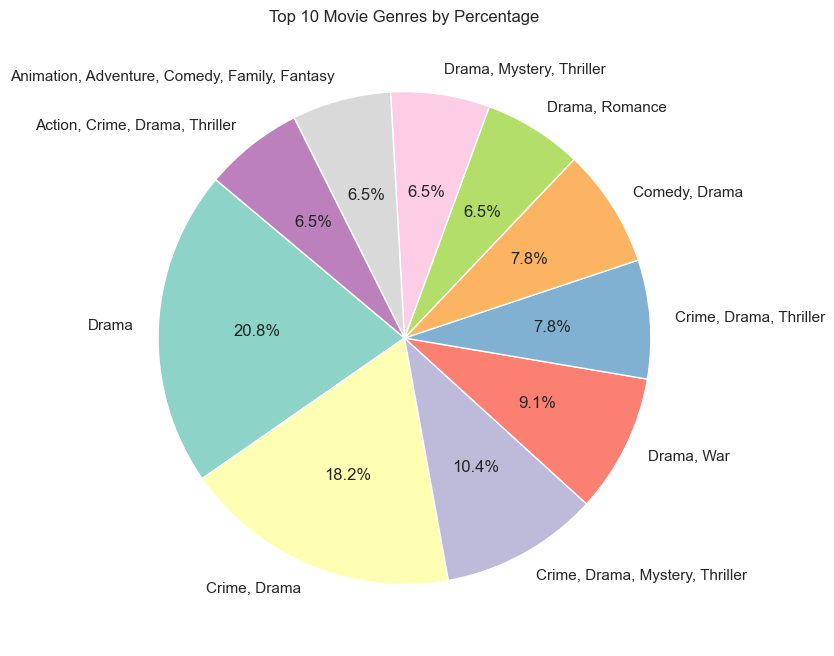

In [34]:
# 1. Pie Chart: نسبة الأنواع
plt.figure(figsize=(8, 8))
genre_percentages = df['Genre'].value_counts(normalize=True).head(10)  # النسب المئوية لأكثر 10 أنواع
genre_percentages.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set3', len(genre_percentages)), startangle=140)
plt.title('Top 10 Movie Genres by Percentage')
plt.ylabel('')  # لإخفاء تسمية المحور y
plt.show()


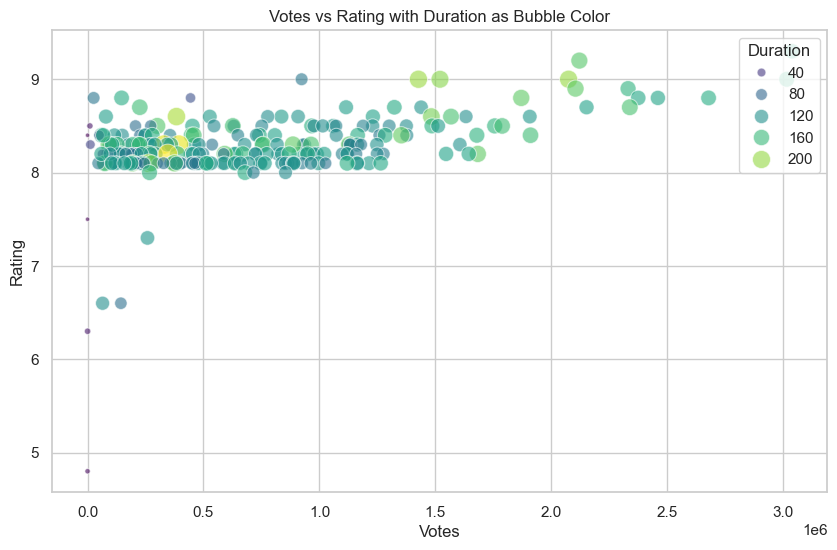

In [35]:
# 5. Bubble Chart: العلاقة بين التصويتات والتقييمات مع مراعاة المدة
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Votes', y='Rating', hue='Duration', size='Duration', sizes=(10, 200), data=df, palette='viridis', alpha=0.6)
plt.title('Votes vs Rating with Duration as Bubble Color')
plt.xlabel('Votes')
plt.ylabel('Rating')
plt.legend(title='Duration', loc='upper right')
plt.show()



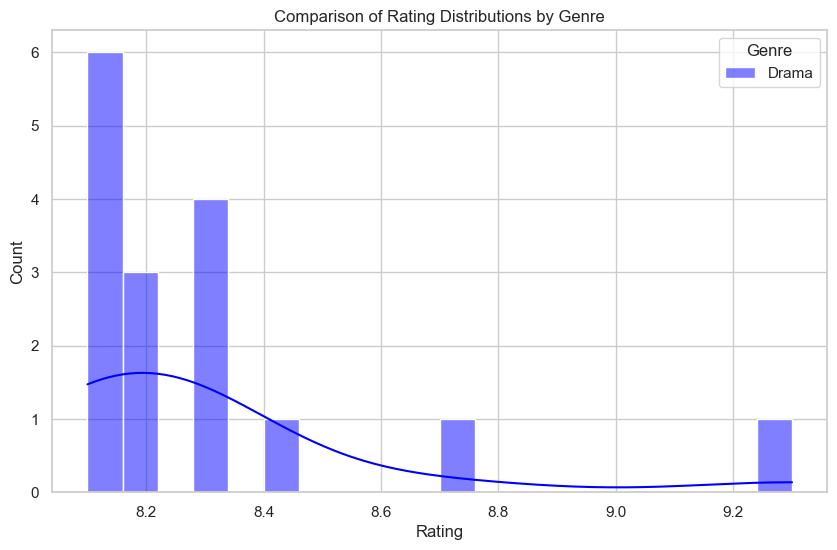

In [36]:
# 6. Histogram: مقارنة التوزيع بين الأنواع
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Genre'] == 'Drama']['Rating'], color='blue', label='Drama', kde=True, bins=20)
sns.histplot(df[df['Genre'] == 'Action']['Rating'], color='red', label='Action', kde=True, bins=20)
plt.legend(title='Genre')
plt.title('Comparison of Rating Distributions by Genre')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


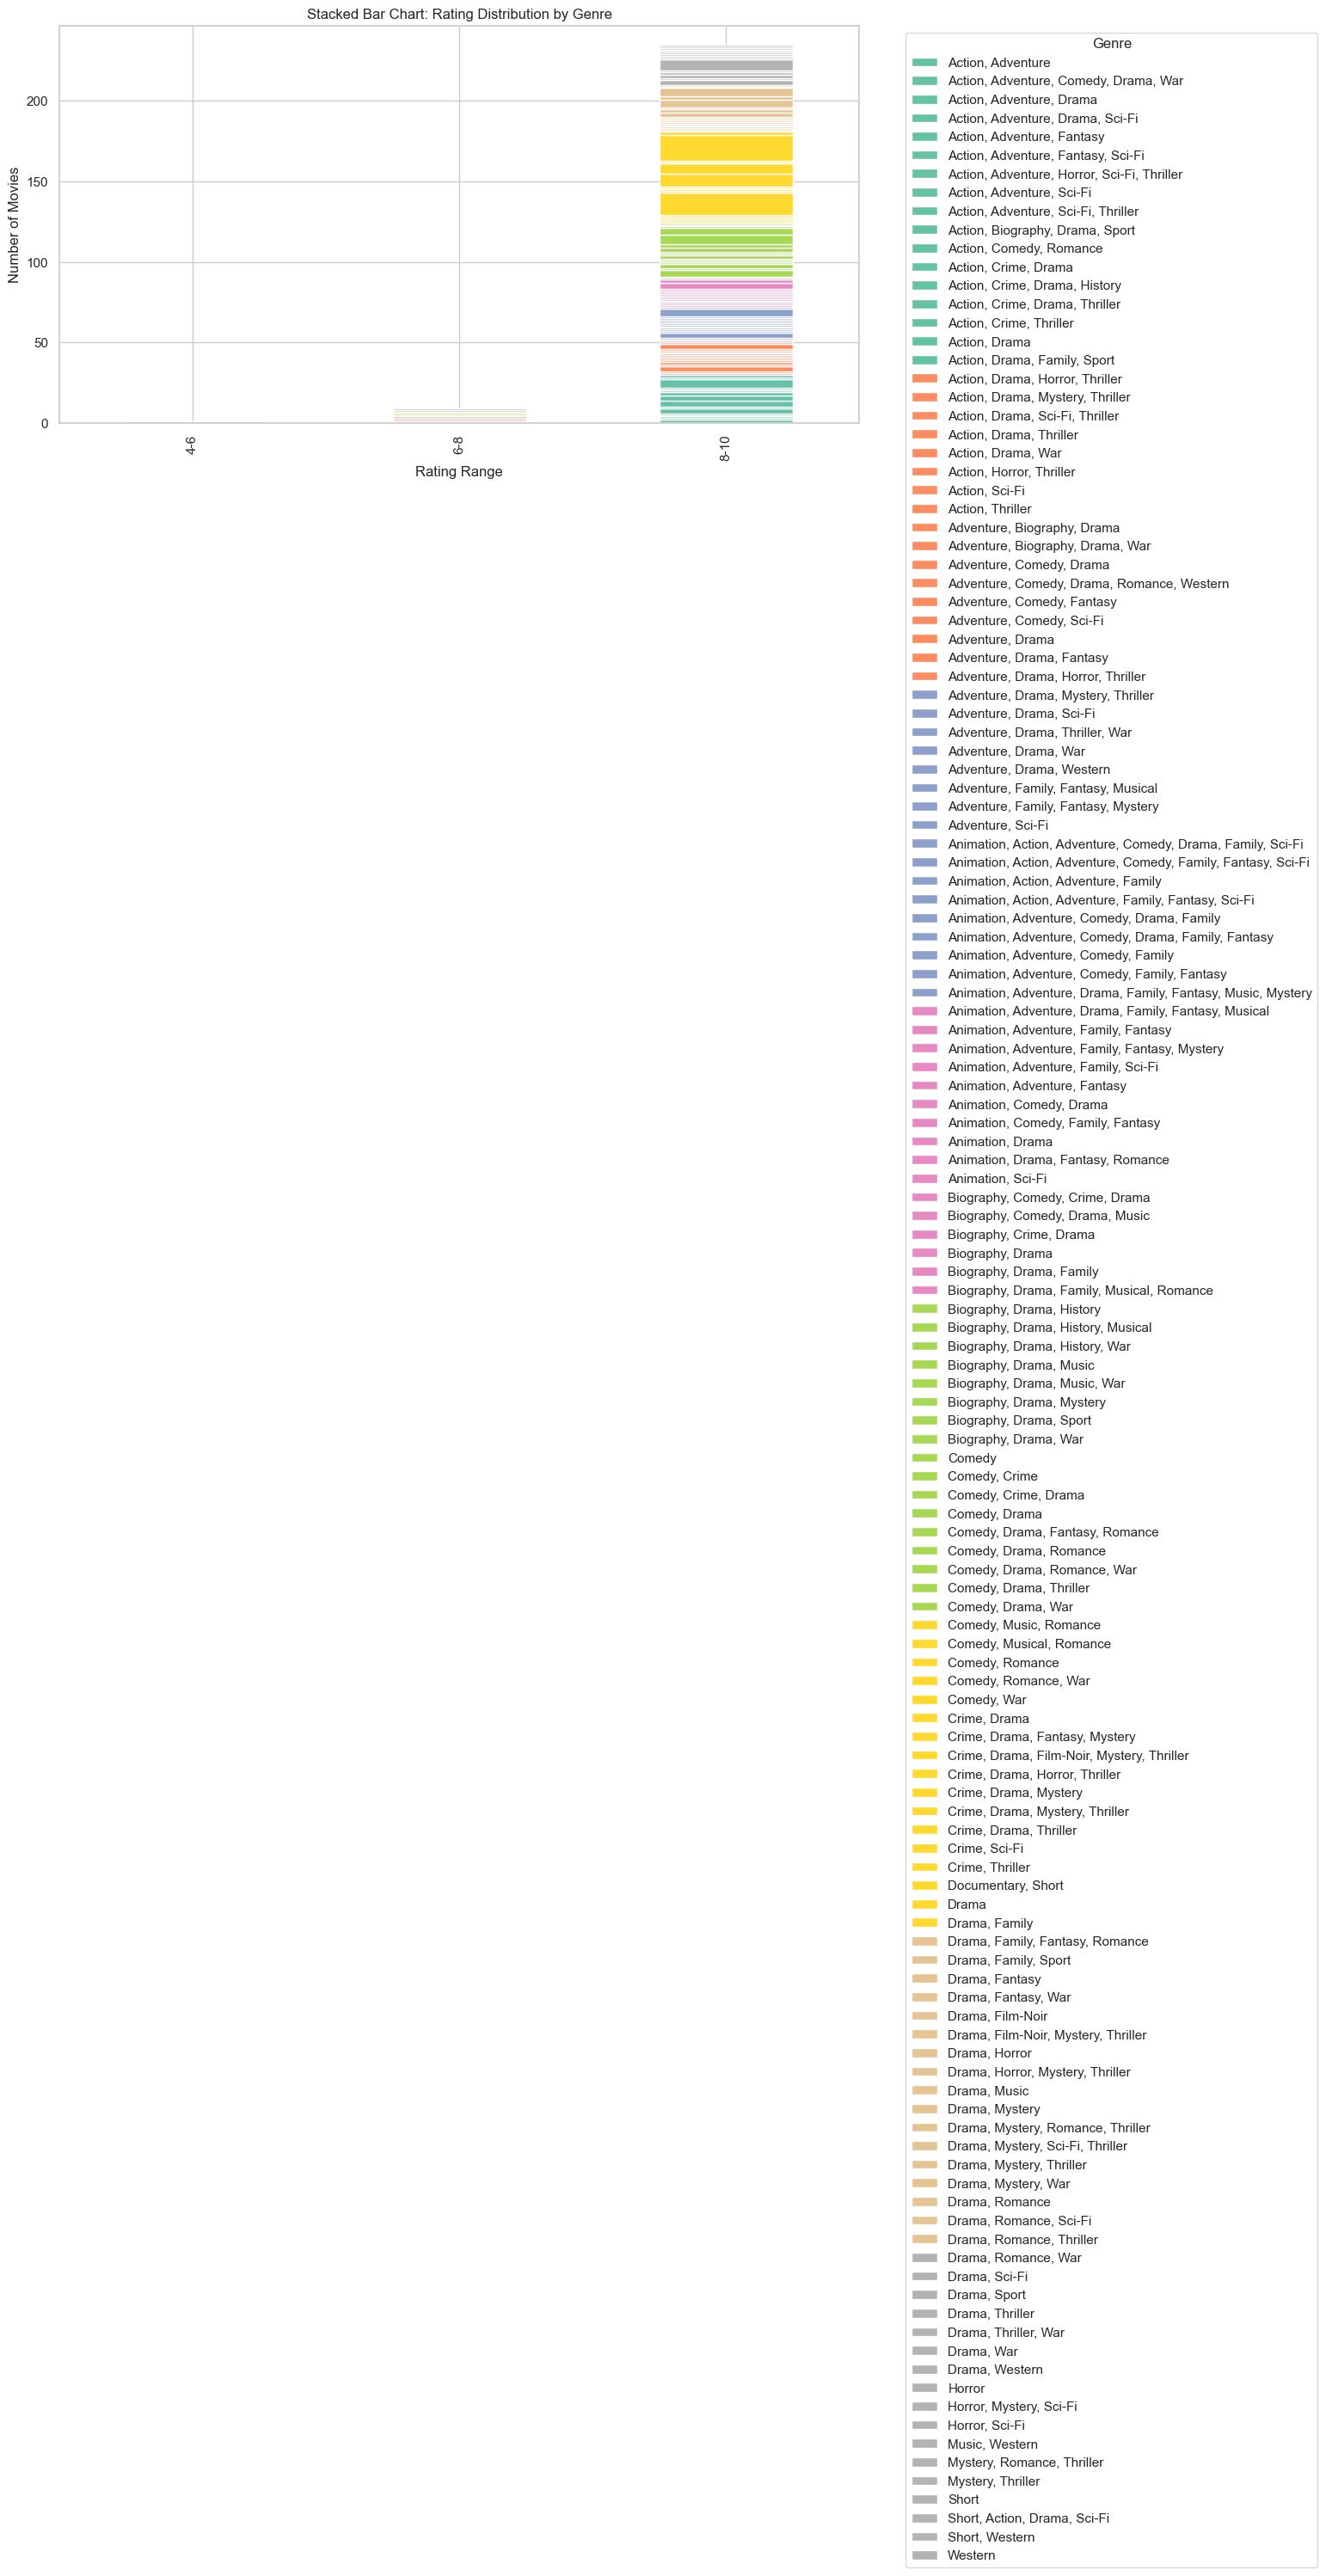

In [37]:
# 7. Stacked Bar Chart: التوزيع حسب الأنواع والتقييمات
rating_bins = pd.cut(df['Rating'], bins=[0, 4, 6, 8, 10], labels=['0-4', '4-6', '6-8', '8-10'])
genre_rating = pd.crosstab(rating_bins, df['Genre'])
genre_rating.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Stacked Bar Chart: Rating Distribution by Genre')
plt.xlabel('Rating Range')
plt.ylabel('Number of Movies')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


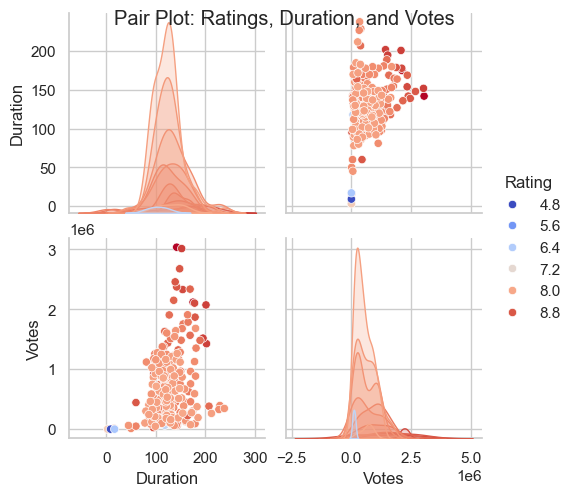

In [38]:
# 8. Pair Plot: التحقق من العلاقات بين المتغيرات
sns.pairplot(df[['Rating', 'Duration', 'Votes']], kind='scatter', hue='Rating', palette='coolwarm')
plt.suptitle('Pair Plot: Ratings, Duration, and Votes')
plt.show()


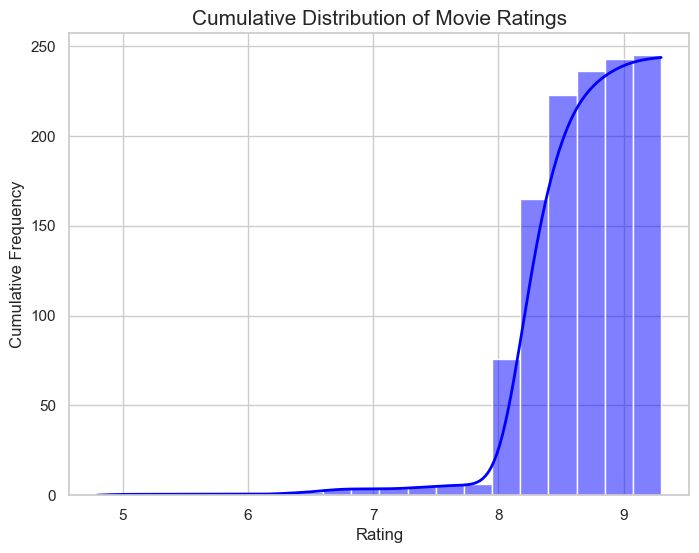

In [39]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=20, kde=True, cumulative=True, color='blue', line_kws={'color': 'red', 'lw': 2})
plt.title('Cumulative Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Cumulative Frequency', fontsize=12)
plt.show()

### Delete Outliers 

In [40]:
# delete Outliers in Votes
Q1 = df['Votes'].quantile(0.25)
Q3 = df['Votes'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Votes'] >= (Q1 - 1.5 * IQR)) & (df['Votes'] <= (Q3 + 1.5 * IQR))]
print(f"The number of outlier movies based on their votes: {outliers.shape[0]}")
display(outliers[['Title', 'Duration', 'Rating','Votes']])

The number of outlier movies based on their votes: 240


,Title,Duration,Rating,Votes
1,The Godfather,175.0,9.2,2120846.0
3,The Godfather Part II,202.0,9.0,1426866.0
4,12 Angry Men,96.0,9.0,923079.0
5,The Lord of the Rings: The Return of the King,201.0,9.0,2074418.0
6,Schindler's List,195.0,9.0,1519823.0
...,...,...,...,...
245,Into the Wild,148.0,8.0,678539.0
246,Groundhog Day,101.0,8.0,715547.0
247,The Help,146.0,8.1,512121.0
248,Amores Perros,154.0,8.0,267221.0


In [41]:
# delete Outliers in Release Year
Q1 = df['Release Year'].quantile(0.25)
Q3 = df['Release Year'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Release Year'] >= (Q1 - 1.5 * IQR)) & (df['Release Year'] <= (Q3 + 1.5 * IQR))]
print(f"The number of outlier movies based on their year: {outliers.shape[0]}")
display(outliers[['Title', 'Duration', 'Rating', 'Votes', 'Release Year']])


The number of outlier movies based on their year: 245


,Title,Duration,Rating,Votes,Release Year
0,The Shawshank Redemption,142.0,9.3,3038284.0,1994
1,The Godfather,175.0,9.2,2120846.0,1972
2,The Dark Knight,152.0,9.0,3015043.0,2008
3,The Godfather Part II,202.0,9.0,1426866.0,1974
4,12 Angry Men,96.0,9.0,923079.0,1957
...,...,...,...,...,...
245,Into the Wild,148.0,8.0,678539.0,2007
246,Groundhog Day,101.0,8.0,715547.0,1993
247,The Help,146.0,8.1,512121.0,2011
248,Amores Perros,154.0,8.0,267221.0,2000


In [42]:
# delete Outliers in Duration
Q1 = df['Duration'].quantile(0.25)
Q3 = df['Duration'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Duration'] < (Q1 - 1.5 * IQR)) | (df['Duration'] > (Q3 + 1.5 * IQR))]
print(f"The number of outlier movies based on their duration: {outliers.shape[0]}")
display(outliers[['Title', 'Duration', 'Rating']])


The number of outlier movies based on their duration: 11


,Title,Duration,Rating
22,Seven Samurai,207.0,8.6
28,Star Wars: Episode IV: A New Hope - Deleted Sc...,16.0,8.5
51,Once Upon a Time in the West,3.0,8.4
86,Once Upon a Time in America,229.0,8.3
101,Lawrence of Arabia,227.0,8.3
132,For A Few Dollars More,3.0,7.5
161,Gone with the Wind,238.0,8.2
182,Ben-Hur,212.0,8.1
200,Sherlock Jr.,45.0,8.2
229,The Passion of Joan of Arc,9.0,4.8


In [43]:
print(f"Dataset shape after removing outliers: {df.shape}")


Dataset shape after removing outliers: (245, 8)


In [44]:
df[['Title', 'Rating']].head(10)

,Title,Rating
0,The Shawshank Redemption,9.3
1,The Godfather,9.2
2,The Dark Knight,9.0
3,The Godfather Part II,9.0
4,12 Angry Men,9.0
5,The Lord of the Rings: The Return of the King,9.0
6,Schindler's List,9.0
7,Pulp Fiction,8.9
8,The Lord of the Rings: The Fellowship of the Ring,8.9
10,Forrest Gump,8.8


In [45]:
  # تأكدنا أن Rating رقمي
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# أفلام بتقييم عالي مثلا >= 8.5
high_rated_movies = df[df['Rating'] >= 8.5]

# أفلام بتقييم منخفض مثلا <= 4.5
low_rated_movies = df[df['Rating'] <= 5.0]

# نطبعهم
print("films with high rating ")
display(high_rated_movies[['Title', 'Rating', 'Votes', 'Genre', 'Duration']])

print("films with low rating  ")
display(low_rated_movies[['Title', 'Rating', 'Votes', 'Genre', 'Duration']])



films with high rating 


,Title,Rating,Votes,Genre,Duration
0,The Shawshank Redemption,9.3,3038284.0,Drama,142.0
1,The Godfather,9.2,2120846.0,"Crime, Drama",175.0
2,The Dark Knight,9.0,3015043.0,"Action, Crime, Drama, Thriller",152.0
3,The Godfather Part II,9.0,1426866.0,"Crime, Drama",202.0
4,12 Angry Men,9.0,923079.0,"Crime, Drama",96.0
5,The Lord of the Rings: The Return of the King,9.0,2074418.0,"Adventure, Drama, Fantasy",201.0
6,Schindler's List,9.0,1519823.0,"Biography, Drama, History",195.0
7,Pulp Fiction,8.9,2330862.0,"Crime, Drama",154.0
8,The Lord of the Rings: The Fellowship of the Ring,8.9,2104255.0,"Adventure, Drama, Fantasy",178.0
10,Forrest Gump,8.8,2374781.0,"Drama, Romance",142.0


films with low rating  


,Title,Rating,Votes,Genre,Duration
229,The Passion of Joan of Arc,4.8,13.0,Short,9.0


In [46]:


# تنظيف Rating عبر regex
df['Rating'] = df['Rating'].apply(lambda x: float(re.sub(r'/10$', '', str(x))) if isinstance(x, str) else x)

# تنظيف Duration عبر regex
df['Duration'] = df['Duration'].apply(lambda x: float(re.sub(r'[^0-9]', '', str(x))) if isinstance(x, str) and 'min' in x else x)

# مثال تنظيف Genre: لو عايز نطلع أول جنس فقط
df['Primary Genre'] = df['Genre'].apply(lambda x: re.split(r',\s*', x)[0] if isinstance(x, str) else 'N/A')

# تأكد من الداتا بعد التنظيف
print(df.head())




                      Title  Release Year              Director  \
0  The Shawshank Redemption          1994        Frank Darabont   
1             The Godfather          1972  Francis Ford Coppola   
2           The Dark Knight          2008     Christopher Nolan   
3     The Godfather Part II          1974  Francis Ford Coppola   
4              12 Angry Men          1957          Sidney Lumet   

                                         Main Actors  \
0  Tim Robbins, Morgan Freeman, Bob Gunton, Willi...   
1  Marlon Brando, Al Pacino, James Caan, Richard ...   
2  Christian Bale, Heath Ledger, Aaron Eckhart, M...   
3  Al Pacino, Robert Duvall, Diane Keaton, Robert...   
4  Martin Balsam, John Fiedler, Lee J. Cobb, E.G....   

                            Genre  Rating  Duration      Votes Primary Genre  
0                           Drama     9.3     142.0  3038284.0         Drama  
1                    Crime, Drama     9.2     175.0  2120846.0         Crime  
2  Action, Crime, Drama

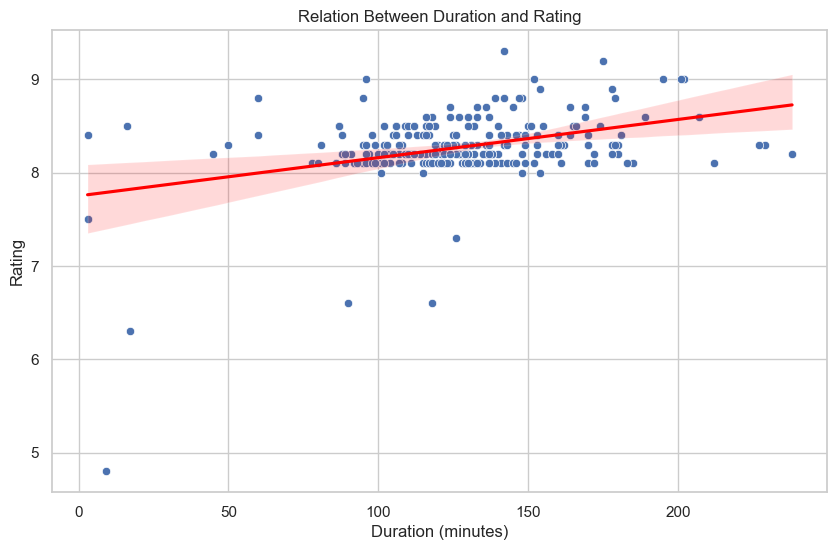

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['Duration'], y=df['Rating'])
sns.regplot(x=df['Duration'], y=df['Rating'], scatter=False, color='red')
plt.title('Relation Between Duration and Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


In [48]:
X = df[['Duration', 'Votes', 'Release Year']]
y = df['Rating']

# تقسيم الداتا
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# بناء نموذج الريجريشن
model = LinearRegression()
model.fit(X_train, y_train)

# التوقعات
y_pred = model.predict(X_test)

# تقييم الأداء
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R²):", r2_score(y_test, y_pred))

# المعاملات
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients)

Mean Squared Error (MSE): 0.047928603952755076
R-squared (R²): 0.0961625974665038
        Feature   Coefficient
0      Duration  3.008934e-03
1         Votes  3.025661e-07
2  Release Year -2.984081e-03


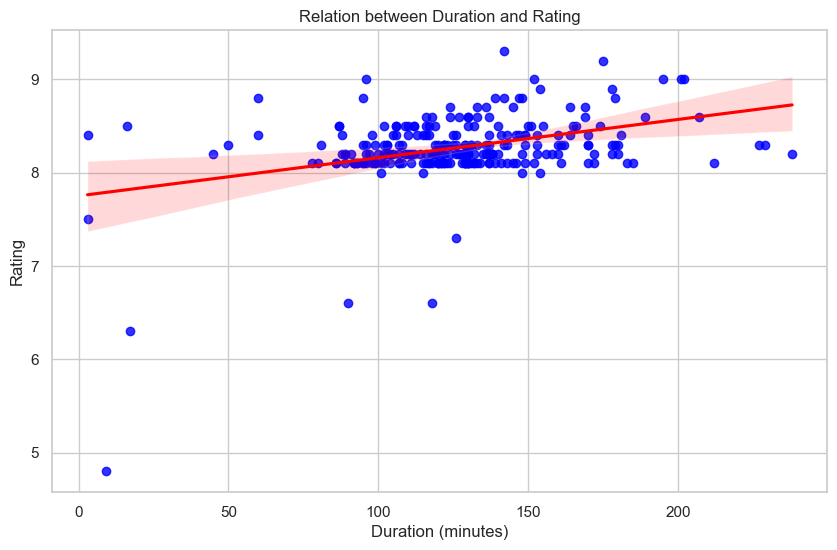

In [49]:
# رسم علاقة Duration مع Rating
plt.figure(figsize=(10,6))
sns.regplot(x=df['Duration'], y=df['Rating'], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Relation between Duration and Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# بعدها نقسم وندرب الموديل بنفس الطريقة
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Multi-variable R-squared Score: {r2:.3f}")
print(f"Multi-variable Mean Squared Error: {mse:.3f}")


Multi-variable R-squared Score: 0.096
Multi-variable Mean Squared Error: 0.048


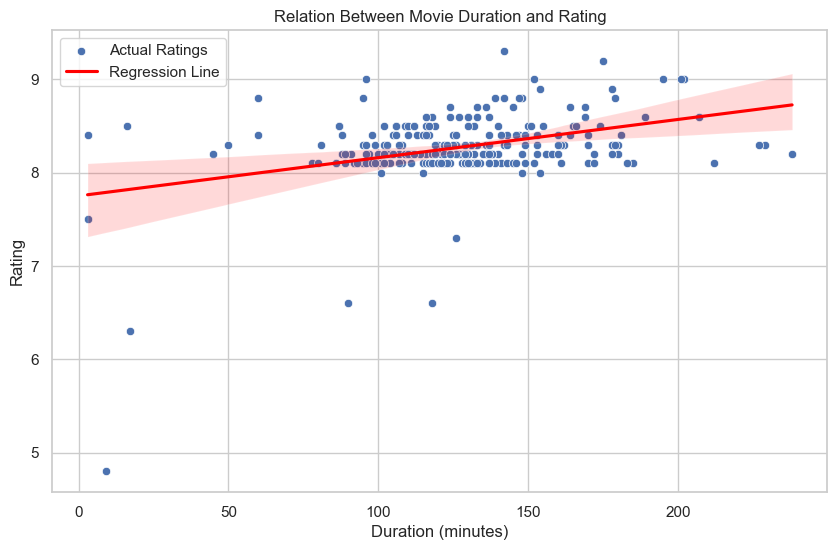

In [51]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['Duration'], y=df['Rating'], label='Actual Ratings')
sns.regplot(x=df['Duration'], y=df['Rating'], scatter=False, color='red', label='Regression Line')
plt.title('Relation Between Movie Duration and Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.show()


Mean Absolute Error (MAE): 0.163
Root Mean Squared Error (RMSE): 0.219


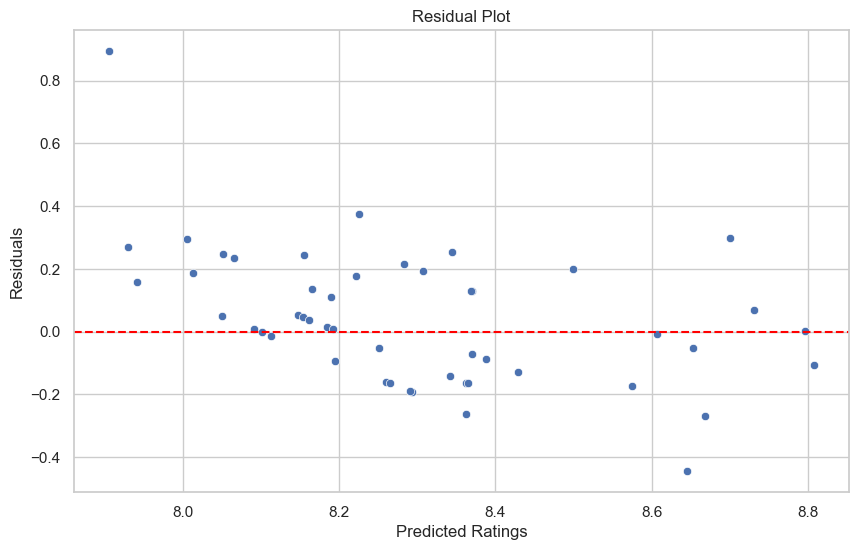

Random Forest R-squared Score: 0.310
Random Forest RMSE: 0.191


In [52]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

# 2. التحقق من الافتراضات - رسم بقايا التنبؤات
residuals = y_test - y_pred

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# 3. تجربة نموذج أكثر تعقيدًا - Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# تقييم الأداء لموديل Random Forest
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print(f"Random Forest R-squared Score: {rf_r2:.3f}")
print(f"Random Forest RMSE: {rf_rmse:.3f}")


In [53]:
# Features and target
X = df[['Votes', 'Duration']]  # اختَر الميزات المناسبة من بياناتك
y = df['Rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [55]:
# التنبؤات
lr_preds = lr_model.predict(X_test_scaled)
rf_preds = rf_model.predict(X_test)

# دالة تقييم
def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} ---")
    print("R² Score:", r2_score(y_true, y_pred))
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print()

evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Random Forest Regressor", y_test, rf_preds)

--- Linear Regression ---
R² Score: 0.08358898192723241
MSE: 0.048595356443575585
MAE: 0.16829121488814328

--- Random Forest Regressor ---
R² Score: 0.17161058749608504
MSE: 0.04392775510204024
MAE: 0.1619999999999989



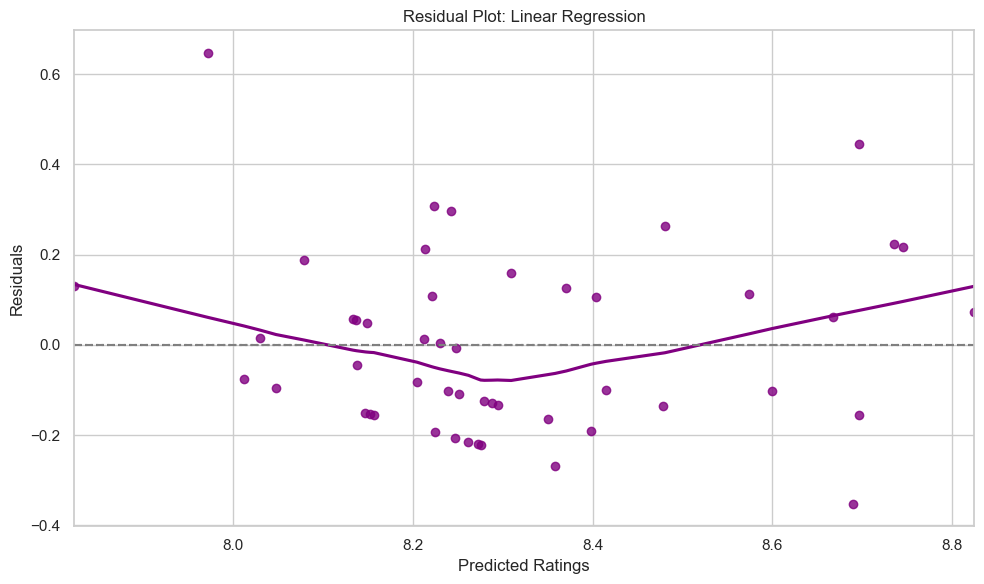

In [56]:
plt.figure(figsize=(10, 6))
sns.residplot(x=lr_preds, y=y_test - lr_preds, lowess=True, color="purple")
plt.title("Residual Plot: Linear Regression")
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

In [57]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R2 Score': [r2_score(y_test, lr_preds), r2_score(y_test, rf_preds)],
    'MSE': [mean_squared_error(y_test, lr_preds), mean_squared_error(y_test, rf_preds)],
    'MAE': [mean_absolute_error(y_test, lr_preds), mean_absolute_error(y_test, rf_preds)]
})



In [60]:
import joblib
joblib.dump(df, "imdb_data.joblib")

['imdb_data.joblib']

In [61]:
import joblib

# حفظ DataFrame في ملف joblib
joblib.dump(df, "imdb_data.joblib")

print("✅ تم حفظ البيانات في imdb_data.joblib بنجاح.")


✅ تم حفظ البيانات في imdb_data.joblib بنجاح.


In [62]:
import joblib
import shutil
import os

# حفظ البيانات
joblib.dump(df, "imdb_data.joblib")

# تحديد المسار الجديد (عدلي حسب مكان ملف app.py)
destination_folder = r"C:\Users\ayaYM\Downloads\Sreamlit-Project"
destination_path = os.path.join(destination_folder, "imdb_data.joblib")

# نقل الملف
shutil.move("imdb_data.joblib", destination_path)

print("✅ تم نقل imdb_data.joblib إلى مجلد Streamlit-Project.")


✅ تم نقل imdb_data.joblib إلى مجلد Streamlit-Project.


In [59]:
import joblib
joblib.dump(df, 'imdb_data.joblit')

['imdb_data.joblit']

In [ ]:
import pandas as pd
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["IMDB_Project"]
collection = db["Movies"]

data = df.to_dict(orient='records')

if data:
    collection.insert_many(data)
    print("✅ تم تخزين البيانات بدون أي تنظيف.")
else:
    print("⚠️ مفيش بيانات تتخزن، الـ DataFrame فاضي.")


✅ تم تخزين البيانات بدون أي تنظيف.
